In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmocean

In [52]:
region = "Kuro_new_2"

In [53]:
data_CESM = np.load(f"/home/hmelzer/work/esn/CESM/Data/ssh_{region}_5d.npy")
lon = np.load(f"/home/hmelzer/work/esn/CESM/Data/lon_{region}.npy")
lat = np.load(f"/home/hmelzer/work/esn/CESM/Data/lat_{region}.npy")
mask = np.load(f"/home/hmelzer/work/esn/CESM/Data/Land_Mask_Kuro.npy")

**IMED**

In [54]:
from imed import transform as ST

In [55]:
sig  =  (0,1,1)
ep   =  1e-3

# data_CESM = np.where(mask == 0, data_CESM_og, np.nan)


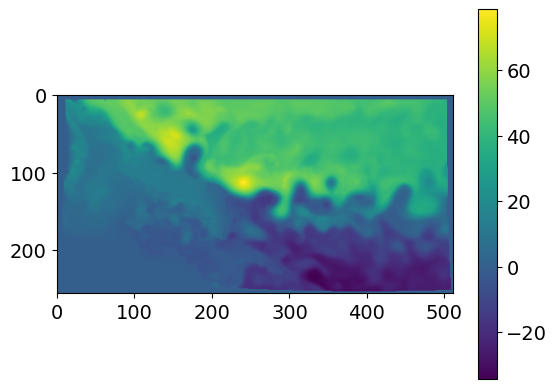

In [56]:
plt.imshow(data_CESM[0,:,:])
plt.colorbar()

In [57]:
import numpy as np
from numpy import pi, prod, exp, ones, ndarray, asarray
from scipy.fft import dct, idct
from scipy.fft import rfftn, irfftn, fftfreq, rfftfreq

NA = np.newaxis


def axis_split(A, axis):
    """helper function to avoid unnecessary copy/numpy.repeat"""
    (Am, Ai, An) = (
        int(prod(A.shape[:axis])),
        A.shape[axis],
        int(prod(A.shape[axis + 1 :])),
    )
    return (Am, Ai, An)


def g12(k_d, sigma, eps):
    """
    Square root of fourier transformed Gaussian.
    Used in both FFT and DCT context where sampled frequencies k_d
    are configured outside of this function.
    when eps is small, positive constant, inverse ST is feasible.
    """
    return (exp(-(k_d ** 2) * sigma ** 2 / 4) + eps) / (1 + eps)


def DCT_1dim(Img, sigma, axis=0, eps=0, inv=False):
    """Perform ST symmetric convolution along axis `axis`"""
    # Sample sqrt of Gaussian in k-space
    k_d = np.linspace(0, pi, Img.shape[axis], dtype=Img.dtype)
    filter = g12(k_d, sigma, eps)

    # Transform to k-space
    img_dct = dct(Img, axis=axis, type=1).reshape(axis_split(Img, axis))

    if inv:
        Img_folded_k = img_dct / filter[NA, :, NA]
    else:
        Img_folded_k = img_dct * filter[NA, :, NA]

    Img_folded = idct(Img_folded_k, axis=1, type=1)

    return Img_folded.reshape(Img.shape)


def FFT_1dim(Img, sigma, axis=0, eps=0, inv=False):
    """Perform ST periodic convolution along axis `axis`"""

    # Transform to k-space
    img_fft = rfftn(Img)
    fft_shape = img_fft.shape
    img_fft = img_fft.reshape(axis_split(img_fft, axis))

    # if last axis, need other k definition for rfft
    if axis == Img.ndim - 1:
        k_d = rfftfreq(2 * fft_shape[axis] - 1) * 2 * pi
        # ensure correct dtype
        k_d = asarray(k_d, dtype=Img.dtype)

    else:
        k_d = fftfreq(fft_shape[axis]) * 2 * pi
        # ensure correct dtype
        k_d = asarray(k_d, dtype=Img.dtype)

    # Gaussian in k-space
    filter = g12(k_d, sigma, eps)

    if inv:
        Img_folded_k = img_fft / filter[NA, :, NA]
    else:
        Img_folded_k = img_fft * filter[NA, :, NA]

    Img_folded = irfftn(Img_folded_k.reshape(fft_shape), s=Img.shape)

    return Img_folded.reshape(Img.shape)


def DCT_ST(imgs, sigma, eps=0, inv=False):
    # automatic d-dimensional standardizing transform
    # via DCT, i.e. symmetric boundary conditions
    # eps is an optional constant added to the OTF to reduce
    # noise amplification when deconvolving
    shape = imgs.shape
    dims = len(shape)

    # Make sigma d-dimensional if not already
    if isinstance(sigma, (list, tuple, ndarray)):
        # if multiple sigmas are given, they must match number of axes
        assert len(sigma) == dims
    else:
        # if sigma is a scalar, it will be used for all axes
        sigma = ones(dims) * sigma

    # do convolution, axis by axis
    for axis in range(dims):
        if sigma[axis] == 0:
            # convolution has no effect
            continue

        if shape[axis] < 2:
            # cant do convolution along this axis
            continue
        imgs = DCT_1dim(imgs, sigma[axis], axis, eps, inv)
    return imgs


def DCT_by_FFT_ST(imgs, sigma, eps=0, inv=False):
    """
    Automatic n-dimensional standardizing transform
    with output like DCT_ST, but using FFT algorithm (periodic convolution).
    eps is an optional constant added to the OTF to reduce
    noise amplification when inverse ST is needed
    """

    orig_shape = imgs.shape
    dims = len(orig_shape)
    # Make sigma d-dimensional if not already
    if isinstance(sigma, (list, tuple, ndarray)):
        # if multiple sigmas are given, they must match number of axes
        assert len(sigma) == dims
    else:
        # if sigma is a scalar, it will be used for all axes
        sigma = ones(dims) * sigma

    for axis in range(dims):
        if sigma[axis] == 0:
            # convolution has no effect
            continue
        if orig_shape[axis] < 3:
            print(f"Skipping axis={axis} with size {orig_shape[axis]}")
            # cant do convolution along this axis
            continue

        # mirror image along axis `axis`
        imgs_reverse = np.flip(imgs, axis=axis)
        # for DCT equivalence
        imgs_reverse = imgs_reverse.take(
            indices=range(1, imgs_reverse.shape[axis] - 1), axis=axis
        )
        imgs = np.concatenate((imgs, imgs_reverse), axis=axis)
        imgs = FFT_1dim(imgs, sigma[axis], axis, eps, inv)

        # Cut to original shape before moving on to other axis
        imgs = imgs.take(indices=range(orig_shape[axis]), axis=axis)

    return imgs


def FFT_ST(imgs, sigma, eps=0, inv=False):
    """
    n-dimensional standardizing transform via FFT.
    Uses per-axis mirroring to reduce edge discontinuities
    eps is an optional constant added to the OTF to reduce
    noise amplification when inverse ST is needed
    """
    orig_shape = imgs.shape
    dims = len(orig_shape)

    # Make sigma d-dimensional if not already
    if isinstance(sigma, (list, tuple, ndarray)):
        # if multiple sigmas are given, they must match number of axes
        assert len(sigma) == dims
    else:
        # if sigma is a scalar it will be used for all axes
        sigma = ones(dims) * sigma

    for axis in range(dims):
        if sigma[axis] == 0:
            # convolution has no effect
            continue

        if orig_shape[axis] < 2:
            # can't do convolution along this axis
            continue

        imgs = FFT_1dim(imgs, sigma[axis], axis, eps, inv)

    return imgs


In [58]:
import numpy as np

def transform(
    volume,
    sigma,
    inv=False,
    eps=0,
    method="DCT",
):
    """
    Performs Gaussian standardizing transform (ST) on data volume.
    (docstring unchanged for brevity)
    """
    volume = np.asarray(volume)

    # Check for NaNs
    nan_mask = np.isnan(volume)
    has_nans = nan_mask.any()

    # Fill NaNs temporarily (e.g., with zeros or interpolation)
    if has_nans:
        volume_filled = np.where(nan_mask, 0, volume)
    else:
        volume_filled = volume

    # Apply the selected transform method
    if method == "DCT":
        volume_ST = DCT_ST(volume_filled, sigma, eps, inv=inv)
    elif method == "FFT":
        volume_ST = FFT_ST(volume_filled, sigma, eps, inv=inv)
    else:
        raise NameError(
            f"`method` must be 'DCT' or 'FFT', not '{method}'.\nReturning original volume."
        )

    # Restore NaNs if they were present
    if has_nans:
        volume_ST[nan_mask] = np.nan

    return volume_ST


In [59]:
data_ST = transform(data_CESM, sigma = sig, inv = False, eps = ep, method = 'DCT')

In [60]:
data_snapshot = data_CESM[0,:,:]
data_ST_snapshot = data_ST[0,:,:]

In [61]:
plt.rcParams.update({'font.size': 14})


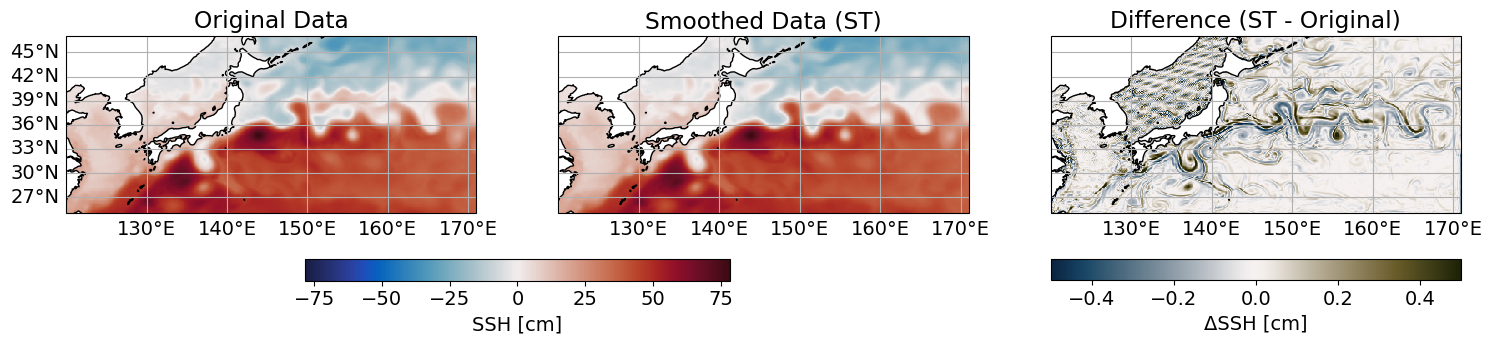

In [62]:
# Compute the difference
diff = data_ST_snapshot - data_snapshot

# Determine symmetric vmin/vmax for data and data_ST
vlim = np.nanmax(np.abs([data_snapshot, data_ST_snapshot]))

# Set symmetric vlim for difference manually
vlim_diff = 0.5

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles for each subplot
titles = ['Original Data', 'Smoothed Data (ST)', 'Difference (ST - Original)']
cmaps = [cmocean.cm.balance, cmocean.cm.balance, cmocean.cm.diff]
vlims = [(-vlim, vlim), (-vlim, vlim), (-vlim_diff, vlim_diff)]
datasets = [data_snapshot, data_ST_snapshot, diff]

# Store the QuadMesh objects
pcms = []

for i, (ax, title, cmap, (vmin, vmax), dat) in enumerate(zip(axes, titles, cmaps, vlims, datasets)):
    pcm = ax.pcolormesh(
        lon, lat, dat,
        shading='auto',
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )
    pcms.append(pcm)
    
    ax.add_feature(cfeature.LAND, facecolor='white', zorder=1)
    ax.coastlines()
    ax.set_title(title)
    ax.set_extent(
        [lon.min() + 1, lon.max() - 1, lat.min() + 1, lat.max() - 1],
        crs=ccrs.PlateCarree()
    )

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    gl.top_labels = False
    gl.right_labels = False

    # Remove y-axis labels for 2nd and 3rd plots
    if i > 0:
        gl.left_labels = False

# Shared colorbar under the first two plots
cbar1 = fig.colorbar(
    pcms[0], ax=axes[:2],
    orientation='horizontal', fraction=0.046, pad=0.1
)
cbar1.set_label('SSH [cm]')

# Separate colorbar under the third plot
cbar2 = fig.colorbar(
    pcms[2], ax=axes[2],
    orientation='horizontal', fraction=0.046, pad=0.1
)
cbar2.set_label('ΔSSH [cm]')

# Save and show
plt.savefig("IMED.png", dpi=300, bbox_inches="tight")
plt.show()


**Input Mappings**

In [63]:
from esn_dev.input_map import make_operation

In [64]:
def get_operation_outputs(img, specs):
    """
    Apply each input map operation to an image and return the raw (unscaled) outputs.

    Args:
        img (np.ndarray): 2D input image.
        specs (list of dict): List of operation specs.

    Returns:
        dict[str, np.ndarray]: Dictionary mapping operation names to output arrays.
    """
    results = {}
    for i, spec in enumerate(specs):
        op = make_operation(spec)
        raw_op = op.op  # remove ScaleOp wrapper
        out = raw_op(img)

        # Try to reshape if 2D
        try:
            shape = raw_op.output_shape(img.shape)
            out = out.reshape(shape)
        except:
            pass  # leave flat if can't reshape

        op_name = f"{i:02d}_{spec['type']}"
        results[op_name] = out

    return results

In [65]:
img = data_snapshot

# Your specs
k = 0.1
input_size = img.size
specs = [
    {"type": "pixels", "size": (10, 10), "factor": k},
    {"type": "conv", "size": (10, 10), "kernel": "gauss",  "factor": k},
    {"type": "conv", "size": (10, 10), "kernel": "random",  "factor": k},
    {"type": "gradient", "factor": 0.001},
    {"type": "vorticity", "factor": 0.001},
    {"type": "dct", "size": (10, 10), "factor": k},
    {"type": "random_weights", "input_size": input_size, "hidden_size": 10000, "factor": 10}
]

# Get outputs
outputs = get_operation_outputs(img, specs)


In [66]:
pixels         = outputs["00_pixels"]
conv_gauss     = outputs["01_conv"]
conv_random    = outputs["02_conv"]
gradient       = outputs["03_gradient"]
vorticity      = outputs["04_vorticity"]
dct            = outputs["05_dct"]
rand_weights   = outputs["06_random_weights"]


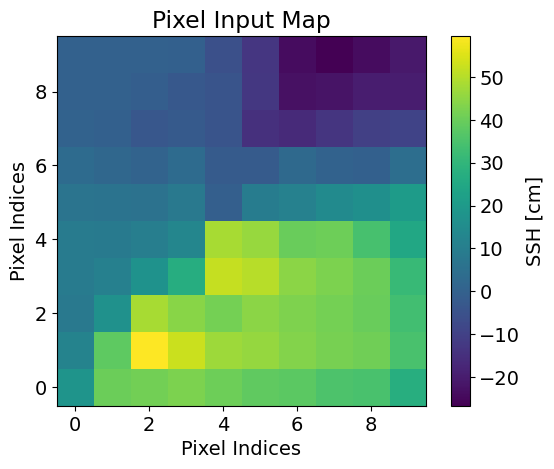

In [67]:
plt.figure()
plt.imshow(pixels, origin='lower')
plt.colorbar(label="SSH [cm]")
plt.title("Pixel Input Map")
plt.xlabel("Pixel Indices")
plt.ylabel("Pixel Indices")
plt.savefig("figures/pixels.png", dpi=300, bbox_inches="tight")
plt.show()

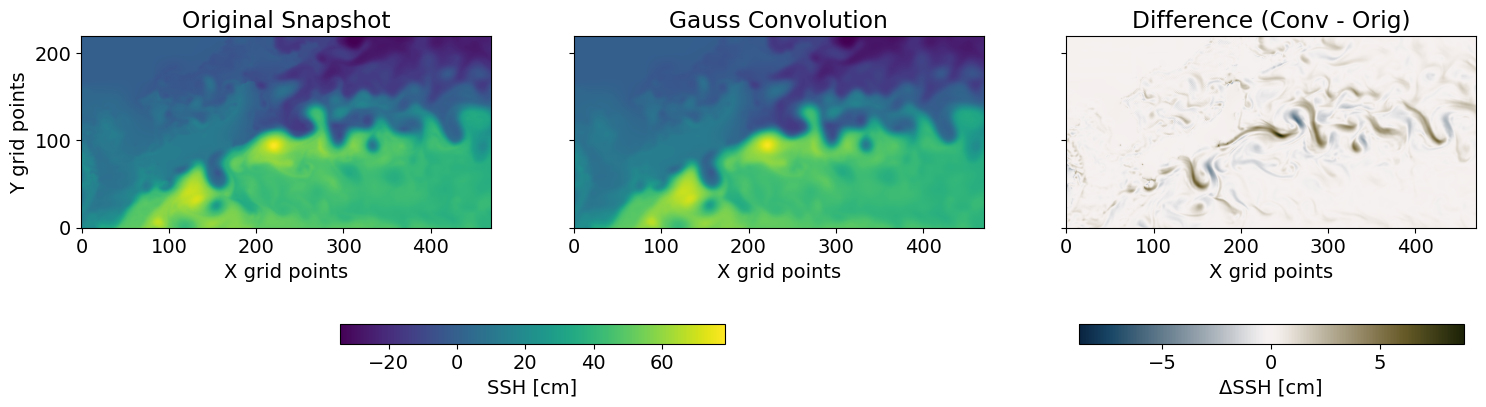

In [68]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
conv = conv_gauss[ymin:ymax, xmin:xmax]
diff = conv - orig

# Common vmin/vmax for orig and conv
vmin = min(orig.min(), conv.min())
vmax = max(orig.max(), conv.max())

# Symmetric range for difference
diff_absmax = np.abs(diff).max()

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Plot original
im0 = axs[0].imshow(orig, origin='lower', vmin=vmin, vmax=vmax)
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")  # Only y-label here

# Plot convolved
im1 = axs[1].imshow(conv, origin='lower', vmin=vmin, vmax=vmax)
axs[1].set_title("Gauss Convolution")
axs[1].set_xlabel("X grid points")

# Plot difference with symmetric color limits
im2 = axs[2].imshow(diff, origin='lower', cmap=cmocean.cm.diff, vmin=-diff_absmax, vmax=diff_absmax)
axs[2].set_title("Difference (Conv - Orig)")
axs[2].set_xlabel("X grid points")

# Shared colorbar for original and convolved
cbar = fig.colorbar(im1, ax=axs[:2], orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label("SSH [cm]")

# Symmetric colorbar for difference
cbar_diff = fig.colorbar(im2, ax=axs[2], orientation='horizontal', fraction=0.05, pad=0.25)
cbar_diff.set_label('ΔSSH [cm]')

# plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("figures/Gauss_Conv.png", dpi=300, bbox_inches="tight")
plt.show()


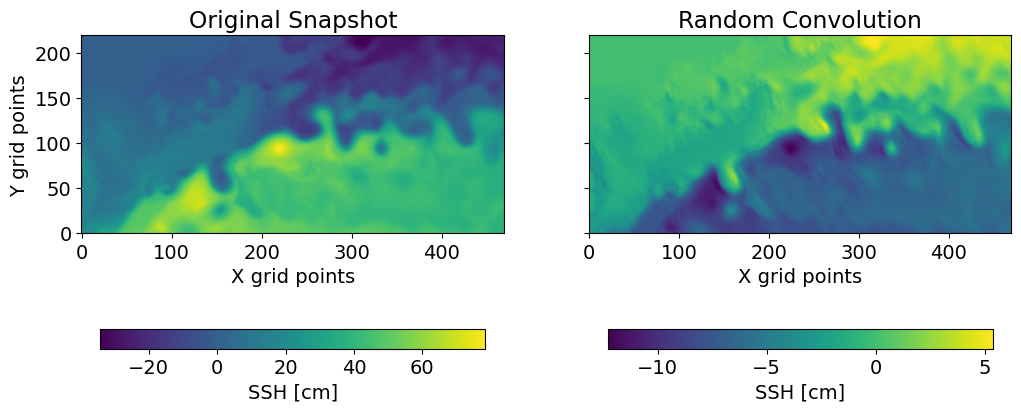

In [69]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
conv = conv_random[ymin:ymax, xmin:xmax]

# Create figure and subplots (only 2 now)
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot original with its own color scale
im0 = axs[0].imshow(orig, origin='lower')
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")

# Plot convolved with its own color scale
im1 = axs[1].imshow(conv, origin='lower')
axs[1].set_title("Random Convolution")
axs[1].set_xlabel("X grid points")

# Independent colorbars for both plots
fig.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.05, pad=0.25).set_label("SSH [cm]")
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.05, pad=0.25).set_label("SSH [cm]")

# Save and show
plt.savefig("figures/rand_conv.png", dpi=300, bbox_inches="tight")
plt.show()


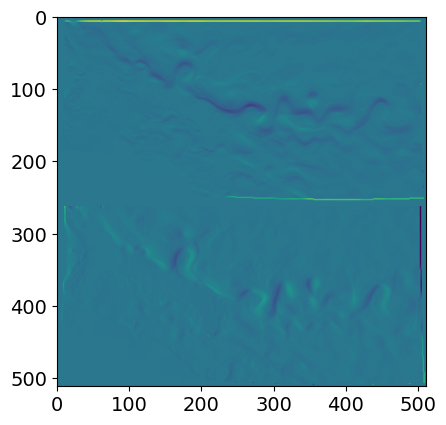

In [70]:
plt.imshow(gradient)

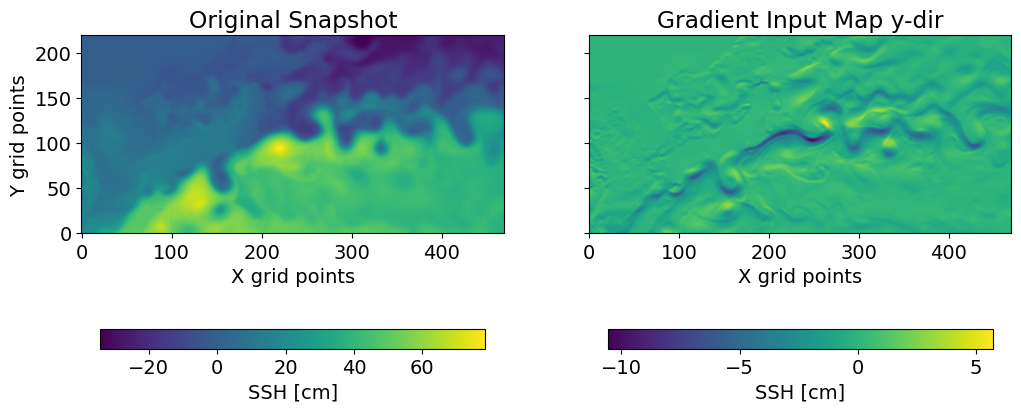

In [71]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
grad = gradient[ymin:ymax, xmin:xmax]

# Create figure and subplots (only 2 now)
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot original with its own color scale
im0 = axs[0].imshow(orig, origin='lower')
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")

# Plot gradient map with its own color scale
im1 = axs[1].imshow(grad, origin='lower')
axs[1].set_title("Gradient Input Map y-dir")
axs[1].set_xlabel("X grid points")

# Independent colorbars for both plots
fig.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.05, pad=0.25).set_label("SSH [cm]")
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.05, pad=0.25).set_label("SSH [cm]")

# Save and show
plt.savefig("figures/grad1.png", dpi=300, bbox_inches="tight")
plt.show()


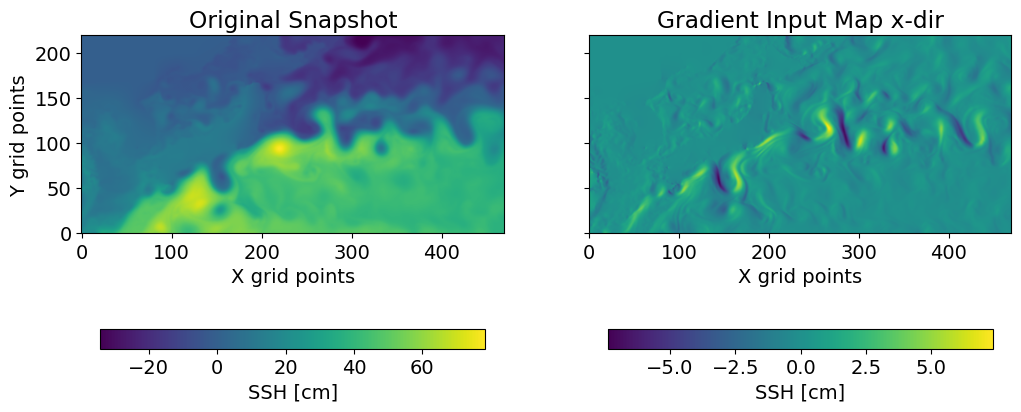

In [72]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
grad = gradient[276:496, xmin:xmax]

# Create figure and subplots (only 2 now)
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot original with its own color scale
im0 = axs[0].imshow(orig, origin='lower')
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")

# Plot x-direction gradient map
im1 = axs[1].imshow(grad, origin='lower')
axs[1].set_title("Gradient Input Map x-dir")
axs[1].set_xlabel("X grid points")

# Independent colorbars for both plots
fig.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.05, pad=0.25).set_label("SSH [cm]")
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.05, pad=0.25).set_label("SSH [cm]")

# Save and show
plt.savefig("figures/grad2.png", dpi=300, bbox_inches="tight")
plt.show()


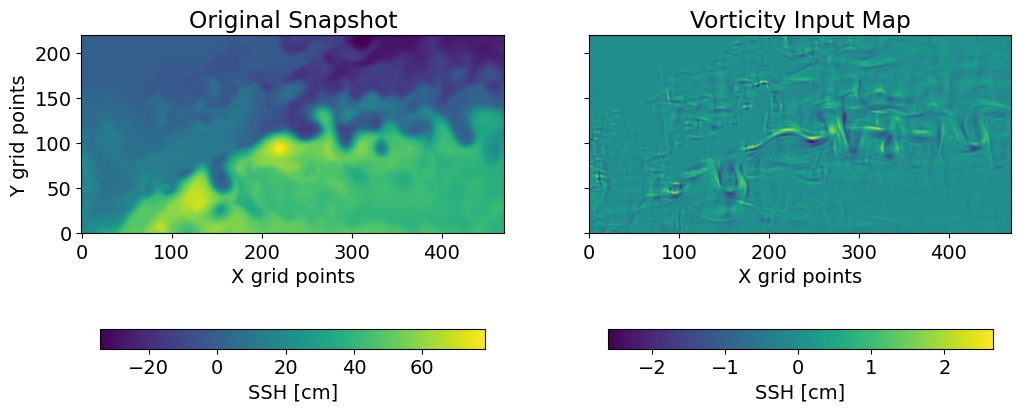

In [76]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
vort = vorticity[ymin:ymax, xmin:xmax]

# Create figure and subplots (only 2 now)
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot original with its own color scale
im0 = axs[0].imshow(orig, origin='lower')
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")

# Plot vorticity map
im1 = axs[1].imshow(vort, origin='lower')
axs[1].set_title("Vorticity Input Map")
axs[1].set_xlabel("X grid points")

# Independent colorbars for both plots
fig.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.05, pad=0.25).set_label("SSH [cm]")
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.05, pad=0.25).set_label("SSH [cm]")

# Save and show
plt.savefig("figures/vort.png", dpi=300, bbox_inches="tight")
plt.show()


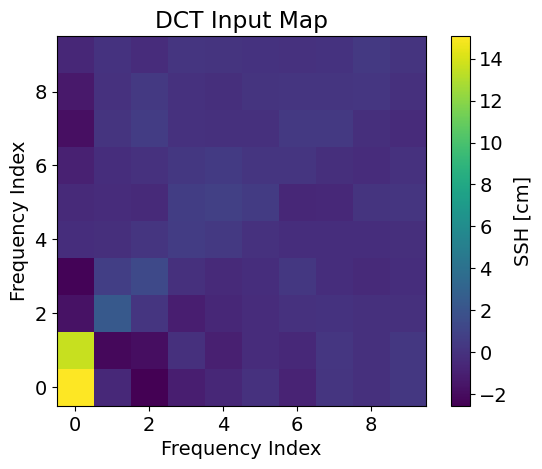

In [74]:
plt.Figure
plt.imshow(dct, origin='lower')
plt.colorbar(label = "SSH [cm]")
plt.title("DCT Input Map")
plt.xlabel("Frequency Index")
plt.ylabel("Frequency Index")
plt.savefig("figures/dct.png")
plt.show()

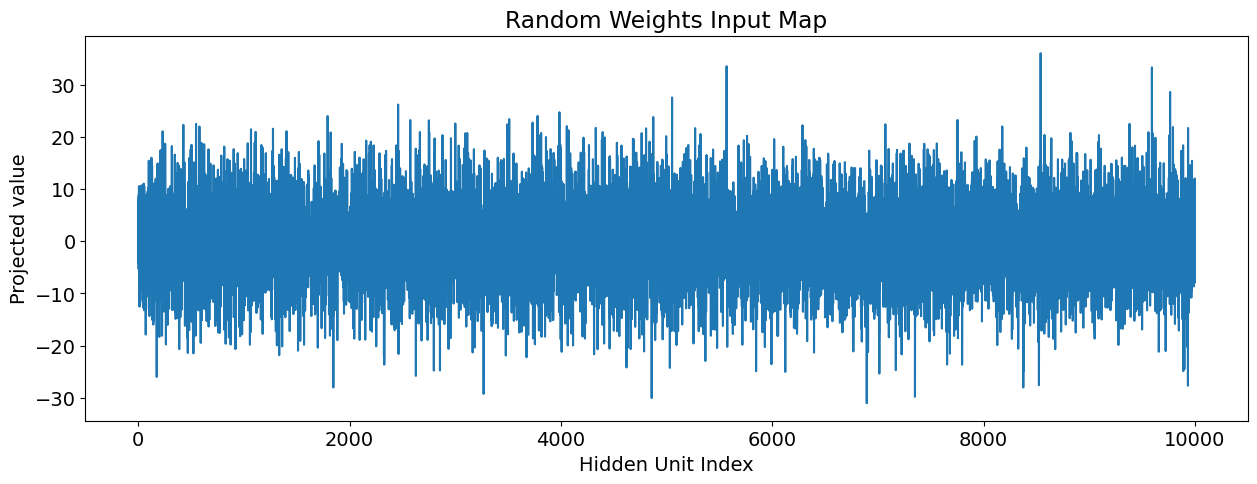

In [77]:
plt.figure(figsize=(15,5))
plt.plot(rand_weights)
plt.title("Random Weights Input Map")
plt.xlabel("Hidden Unit Index")
plt.ylabel("Projected value")
plt.savefig("figures/rand_weights.png")
plt.show()